# Создание циклической GAN для трансформации изображений

Для отладки параметров и обучения модели возьмем задачу преобразования фотографий из летних в зимние

## Подготовка данных

В качестве источника данных для отладки модели я использую [датасет фотографий Йосемитского парка](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/summer2winter_yosemite.zip)

Константы

In [8]:
IMAGE_SIZE = 64
BATCH_SIZE = 16
RESIDUAL_BLOCKS_NUM = 8
BASE_DIR = "/content/gdrive/MyDrive/CycleGAN/summer2winter/"
SAVING_PATH = "/content/gdrive/MyDrive/CycleGAN/lightning/summer2winter.ckpt"

Установка Pytorch Lightning

In [ ]:
!pip install pytorch-lightning

Импорт необходимых библиотек

In [ ]:
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer

from statistics import mean
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

Подключение к источнику данных

In [5]:
from google.colab import drive
 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Метод для загрузки картинок

In [6]:
def fetch_images(dirname):
    images = []
    for _, _, filenames in os.walk(BASE_DIR + dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = BASE_DIR + dirname + "/" + fname
                img = imread(fpath)
                image = resize(img, [IMAGE_SIZE, IMAGE_SIZE])
                images.append(image)
    images = np.array(images, np.float32)
    result = torch.from_numpy(images).permute(0, 3, 2, 1)
    return result

Загрузка картинок

In [9]:
summer_train = fetch_images("summer")
winter_train = fetch_images("winter")
summer_val = fetch_images("test_summer")
winter_val = fetch_images("test_winter")

Метод для отображения нескольких картинок

In [10]:
def print_images(imgs):
    images = imgs.permute(0, 3, 2, 1).numpy()
    plt.figure(figsize=(18, 6))
    for i in range(5):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(images[i])

Печать первых 5 летних фотографий из валидационного датасета

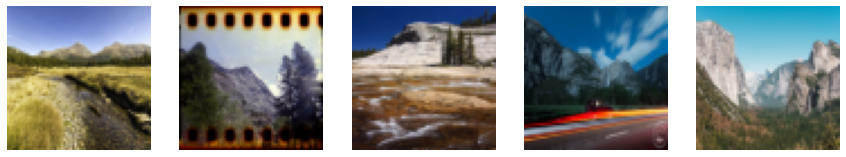

In [ ]:
print_images(summer_val[:5])

Печать первых 5 зимних фотографий из валидационного датасета

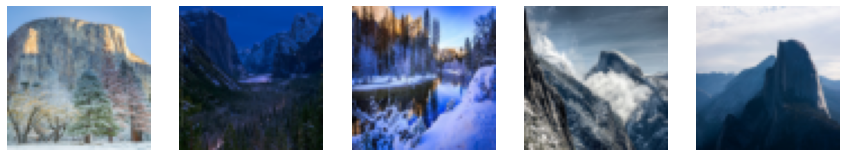

In [ ]:
print_images(winter_val[:5])

Создание загрузчиков данных

In [11]:
train_loader = DataLoader(
    dataset=list(zip(summer_train, winter_train)),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    dataset=list(zip(summer_val, winter_val)),
    batch_size=BATCH_SIZE,
    num_workers=2
)

## Архитектура модели

### Методы создания слоев

Метод для создания сверточного слоя

In [12]:
def make_conv_layer(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

Метод для создания разверточного слоя

In [13]:
def make_deconv_layer(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

### Дискриминаторы

Дискриминаторы в данном случае - это сверточные нейронные сети, которые видят изображение и пытаются классифицировать его как реальное или поддельное. Реальное указывается выводом, близким к 1, а поддельное - близким к 0.

In [14]:
class Discriminator(LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            make_conv_layer(64, 128),
            make_conv_layer(128, 256),
            make_conv_layer(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Генераторы

Генераторы в данном случае - нейросети, которые трансформируют изображения из одного типа в другой.

Остаточный блок

In [15]:
class ResidualBlock(LightningModule):
    
    def __init__(self, channels):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )
        
    def forward(self, x):
        x1 = self.layer_1(x)
        result = x + self.layer_2(x1)
        return result

Генератор

In [16]:
class Generator(LightningModule):
    
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            make_conv_layer(3, 64),
            make_conv_layer(64, 128),
            make_conv_layer(128, 256)
        )
        layers = [ResidualBlock(256)] * RESIDUAL_BLOCKS_NUM
        self.bottleneck = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            make_deconv_layer(256, 128),
            make_deconv_layer(128, 64),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        e = self.encoder(x)
        b = self.bottleneck(e)
        result = self.decoder(b)
        return result

### Функции потерь

Функция потерь дискриминаторов для реальных картинок

In [17]:
def real_mse_loss(D_out):
    return torch.mean((D_out - 1) ** 2)

Функция потерь дискриминаторов для поддельных картинок

In [18]:
def fake_mse_loss(D_out):
    return torch.mean(D_out ** 2)

Функция потерь для реконструкции изображений генераторами

In [19]:
cycle_loss = nn.MSELoss()

### Код для тренировки модели

Контейнеры для хранения значений потерь

In [20]:
summer_losses = []
winter_losses = []
cycle_losses = []
summer_losses_batch = []
winter_losses_batch = []
cycle_losses_batch = []

Код для тренировки модели

In [21]:
class TraiableCycleGAN(LightningModule):

    def __init__(self):
        super().__init__()

    def configure_optimizers(self):
        lr = 0.0002
        beta1 = 0.5
        beta2 = 0.999
        summer_optimizer = AdamW(self.summer_discriminator.parameters(), lr=lr, betas=(beta1, beta2))
        winter_optimizer = AdamW(self.winter_discriminator.parameters(), lr=lr, betas=(beta1, beta2))
        cycle_params = list(self.summer_generator.parameters()) + list(self.winter_generator.parameters())
        cycle_optimizer = AdamW(cycle_params, lr=lr, betas=(beta1, beta2))
        return [summer_optimizer, winter_optimizer, cycle_optimizer]

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        
        summer, winter = batch
        
        # train summer discriminator
        if optimizer_idx == 0:
            real_summer_loss = real_mse_loss(self.summer_discriminator(summer))
            fake_summer_loss = fake_mse_loss(self.summer_discriminator(self.summer_generator(winter)))
            loss = real_summer_loss + fake_summer_loss
            return loss
        
        # train winter discriminator
        if optimizer_idx == 1:
            real_winter_loss = real_mse_loss(self.winter_discriminator(winter))
            fake_winter_loss = fake_mse_loss(self.winter_discriminator(self.winter_generator(summer)))
            loss = real_winter_loss + fake_winter_loss
            return loss
        
        # train generators
        if optimizer_idx == 2:
            
            # compute summer generator loss
            out1 = self.summer_generator(winter)
            loss1 = real_mse_loss(self.summer_discriminator(out1))
        
            # compute winter cycle loss
            out2 = self.winter_generator(out1)
            loss2 = cycle_loss(out2, winter)

            # compute winter generator loss
            out3 = self.winter_generator(summer)
            loss3 = real_mse_loss(self.winter_discriminator(out3))

            # compute summer cycle loss
            out4 = self.summer_generator(out3)
            loss4 = cycle_loss(out4, summer)

            loss = loss1 + loss2 + loss3 + loss4
            return loss

    def validation_step(self, batch, batch_idx):
        
        summer, winter = batch

        # compute summer generator loss
        out1 = self.summer_generator(winter)
        summer_loss = fake_mse_loss(self.summer_discriminator(out1))
        loss1 = real_mse_loss(self.summer_discriminator(out1))
        summer_losses_batch.append(summer_loss.item())
        
        # compute winter cycle loss
        out2 = self.winter_generator(out1)
        loss2 = cycle_loss(out2, winter)

        # compute winter generator loss
        out3 = self.winter_generator(summer)
        winter_loss = fake_mse_loss(self.winter_discriminator(out3))
        loss3 = real_mse_loss(self.winter_discriminator(out3))
        winter_losses_batch.append(winter_loss.item())

        # compute summer cycle loss
        out4 = self.summer_generator(out3)
        loss4 = cycle_loss(out4, summer)

        loss = loss1 + loss2 + loss3 + loss4
        cycle_losses_batch.append(loss.item())
        metrics = {
            "val_loss": loss
        }
        self.log_dict(metrics)
        return metrics

    def on_epoch_end(self):
        if len(summer_losses_batch) > 0:
            summer_losses.append(mean(summer_losses_batch))
            winter_losses.append(mean(winter_losses_batch))
            cycle_losses.append(mean(cycle_losses_batch))
            summer_losses_batch.clear()
            winter_losses_batch.clear()
            cycle_losses_batch.clear()

### CycleGAN

In [22]:
class CycleGAN(TraiableCycleGAN):

    def __init__(self):
        super().__init__()
        self.summer_discriminator = Discriminator()
        self.winter_discriminator = Discriminator()
        self.summer_generator = Generator()
        self.winter_generator = Generator()

    def forward(self, x):
        return x

    @torch.no_grad()
    def generate_winter(self, summer):
        return self.winter_generator(summer)

    @torch.no_grad()
    def generate_summer(self, winter):
        return self.summer_generator(winter)

## Обучение

Тренировка модели

In [ ]:
summer_losses.clear()
winter_losses.clear()
cycle_losses.clear()
model = CycleGAN()
tr = Trainer(gpus=1, max_epochs=1000)
tr.fit(model)
tr.save_checkpoint(SAVING_PATH)

Загрузка параметров тренированной GAN

In [ ]:
model = CycleGAN.load_from_checkpoint(SAVING_PATH)

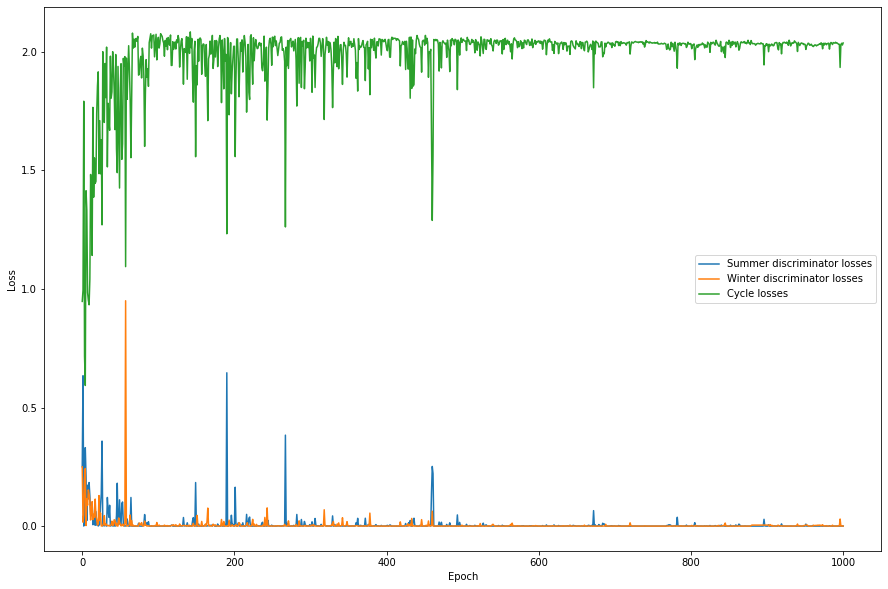

In [24]:
plt.figure(figsize=(15, 10))
plt.plot(summer_losses)
plt.plot(winter_losses)
plt.plot(cycle_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("Summer discriminator losses", "Winter discriminator losses", "Cycle losses"))
plt.show()

## Проверка реконструкции картинок

Проверка реконструкции летних фотографий

Выбор 5 картинок из валидационного датасета

In [ ]:
summer = summer_val[5:10]

Печать картинок

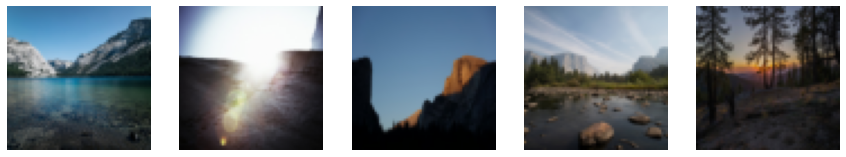

In [ ]:
print_images(summer)

Реконструкция этих же картинок

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


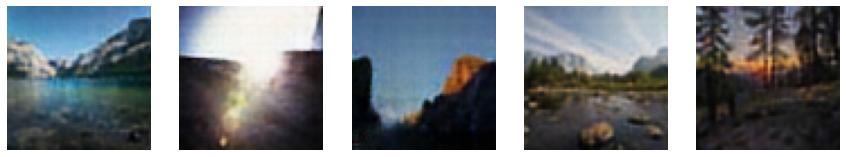

In [ ]:
winter = model.generate_winter(summer)
rec = model.generate_summer(winter)
print_images(rec)

Проверка реконструкции фотографий

Выбор 5 картинок из валидационного датасета

In [ ]:
winter = winter_val[5:10]

Печать картинок

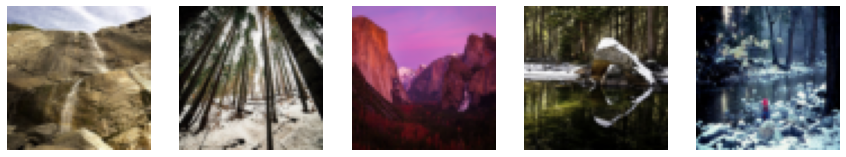

In [ ]:
print_images(winter)

Реконструкция этих же картинок

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


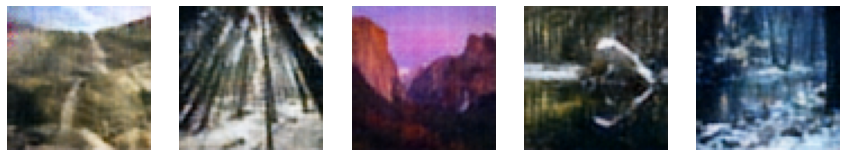

In [ ]:
summer = model.generate_summer(winter)
rec = model.generate_winter(summer)
print_images(rec)

## 1NN accuracy

Проверим качество трансформации изображений с помощью метода одного ближайшего соседа

Формирование выборки картинок

In [ ]:
flatten = nn.Flatten()
winter = flatten(winter_train)
generated = flatten(model.generate_winter(summer_train))
X = torch.cat((winter, generated)).numpy()

Формирование выборки классов

In [ ]:
zeros = torch.zeros(len(winter))
ones = torch.ones(len(winter))
y = torch.cat((ones, zeros)).numpy()

Обучение классификатора

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

Подсчет accuracy score

In [1]:
X_test = flatten(model.generate_winter(summer_val)).numpy()
y_pred = knn.predict(X_test)
score = int(mean(y_pred) * 10000) / 100
print("Accuracy score:", score, "%")

Accuracy score: 92.26 %


Поскольку результат превышает 80 %, GAN качественно генерирует изображения.

## Трансформация фотографий

Трансформация 5 картинок из летних в зимние

Исходные картинки

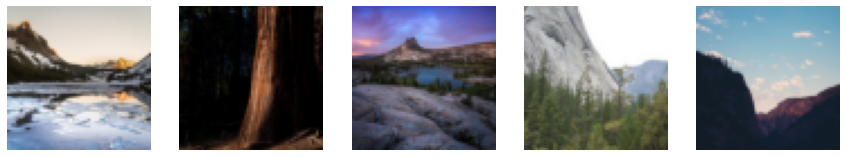

In [ ]:
summer = summer_val[45:50]
print_images(summer)

Трансформированные картинки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


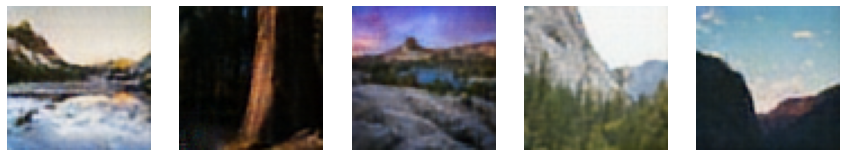

In [ ]:
print_images(model.generate_winter(summer))